It is currently the end of week five of Google Summer of Code 2023. According to the original deliverables table outlined in my proposal, the goal was to have opened a draft PR for the core functionality of the `plot_comparisons`. Subsequently, week six and seven were to be spent further developing the `plot_comparisons` function, and writing tests and a demo notebook for the documentation, respectively. However, at the end of week five, I have a PR open with the majority of the functionality that [marginaleffects](https://vincentarelbundock.github.io/marginaleffects/) has. In addition, I also exposed the `comparisons` function, added tests (which can and will be improved), and have started on documentation.

# Average predictive comparisons

`comparisons` and `plot_comparisons` are a part of Bambi's sub-package `plots` that feature a set of functions used to interpret complex regression models. This sub-package is inspired by the R package [marginaleffects](https://vincentarelbundock.github.io/marginaleffects/articles/predictions.html#conditional-adjusted-predictions-plot). These two functions allow the modeler to **compare** the predictions made by a model for different contrasts and covariate values.

Due to the link function in a GLM, there are typically three quantities of interest to interpret:

1. the linear predictor $\eta = X\beta$ where $X$ is an $n$ x $p$ matrix of explanatory variables.
2. the mean $\mu = g^{-1}(\eta)$ where the link function $g(\cdot)$ relates the linear predictor to the mean of the outcome variable $\mu = g^{-1}(\eta) = g^{-1}(X\beta)$
3. the response variable $Y \sim \mathcal{D}(\mu, \theta)$ where $\mu$ is the mean parameter and $\theta$ is (possibly) a vector that contains all the other "nuissance" parameters of the distribution.
 
With GLMs, $\eta$ is linear in the parameters, but non-linear in relation to the outputs $Y$ due to the link function $g$. Thus, as modelers, we are usually more interested in interpreting (2) and (3). For example, in logistic regression, the linear predictor is on the log-odds scale, but the response variable is on the probability scale. In Poisson regression, the linear predictor is on the log-scale, but the response variable is on the count scale. Referring back to logistic regression, a specified difference in one of the $x$ variables does _not_ correspond to a constant difference in the the probability of the outcome.

It is often helpful with GLMs, to the modeler and audience, to have a summary that gives the expected difference in the outcome corresponding to a unit difference in each of the input variables. Thus, the goal of `comparisons` and `plot_comparisons` is to provide the modeler with a summary and visualization of the average predicted comparisons.

## Methodology

Here, I adopt the notation from Chapter 14.4 of [Regression and Other Stories](https://avehtari.github.io/ROS-Examples/) to describe the methodology of average predicted comparisons. 

Assume we have fit a Bambi model predicting an outcome $Y$ based on inputs $X$ and parameters $\theta$. Consider the following scalar inputs:

$$u: \text{the input of interest}$$
$$v: \text{all the other inputs}$$
$$X = (u, v)$$

Suppose for the input of interest, we are interested in comparing $u^{\text{high}}$ to $u^{\text{low}}$ (perhap age = $60$ and $40$ respectively) with all other inputs $v$ held constant. The _predictive difference_ in the outcome changing **only** $u$ is:

$$\text{predictive difference (comparison)} = \mathbb{E}(y|u^{\text{high}}, v, \theta) - \mathbb{E}(y|u^{\text{low}}, v, \theta)$$

Selecting the maximum and minimum values of $u$ and averaging over all other inputs $v$ in the data gives you a new "hypothetical" dataset and corresponds to counting all pairs of transitions of $(u^\text{low})$ to $(u^\text{high})$, i.e., differences in $u$ with $v$ held constant. 

## Implementation

To demonstrase how to compute and plot _average predictive comparisons_ with `comparisons` and `plot_comparions`, we model and predict how many fish are caught by visitors at a state park. Many visitors catch zero fish, either because they did not fish at all, or because they were unlucky. We would like to explicitly model this bimodal behavior (zero versus non-zero) using a Zero Inflated Poisson model, and to compare how different inputs of interest $u$ and other covariate values $v$ are associated with the number of fish caught.

In [19]:
#| code-fold: true
import numpy as np
import pandas as pd

import bambi as bmb
from bambi.plots import plot_comparison, comparisons

In [4]:
fish_data = pd.read_stata("http://www.stata-press.com/data/r11/fish.dta")
cols = ["count", "livebait", "camper", "persons", "child"]
fish_data = fish_data[cols]
fish_data["livebait"] = fish_data["livebait"].astype("category")
fish_data["camper"] = fish_data["camper"].astype("category")

In [42]:
fish_model = bmb.Model(
    "count ~ livebait + camper + persons + child", 
    fish_data, 
    family='zero_inflated_poisson'
)

fish_idata = fish_model.fit(
    draws=1000, 
    target_accept=0.95, 
    random_seed=1234, 
    chains=4
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [count_psi, Intercept, livebait, camper, persons, child]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


### Default contrast and conditional values

In both `plot_comparisons` and `comparisons`, $u$ and $v$ are represented by `contrast` and `conditional`, respectively. Lets say we are interested in comparing the number of fish caught for `livebait` = [0, 1] conditional on the number of people.

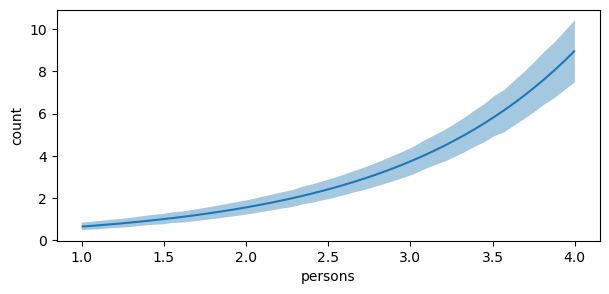

In [44]:
fig, ax = plot_comparison(
    model=fish_model,
    idata=fish_idata,
    contrast="livebait",
    conditional="persons",
) 
fig.set_size_inches(7, 3)

By default, if no value is passed with `contrast`, then the mean or mode is computed (depending on the data type used to fit the model) as the contrast value. As live bait is category data type and no value was passed, the contrast value is [0, 1]. By default, `comparisons` compares $u^\text{high}$ to $u^\text{low}$. Thus, in this example, $u^\text{high}$ = 1 and $u^\text{low}$ = 0. The plot shows us that comparing a group of two people who used live bait and no live bait, the expected difference in the number of fish caught is about $2$. As the number of people in the group increases, the expected difference also increases. 

We can call `comparisons` directly to view a summary dataframe that includes the term $u$ and its contrast, the specified `conditional` covariate, and the expected difference in the outcome with the uncertainty interval (by default the 94% highest density interval is computed). We see that `camper` and `child` are also in the summary dataframe. This is because for unspecified covariates, `comparisons` and `plot_comparisons` computes a default value (mean or mode based on the data type of the covariate). Thus, $v$ = `persons`, `camper`, `child`.

In [45]:
comparisons_df = comparisons(
    model=fish_model,
    idata=fish_idata,
    contrast="livebait",
    conditional="persons",
)
comparisons_df.head(10)

,term,contrast,persons,camper,child,estimate,hdi_0.03%,hdi_0.97%
0,livebait,"(0.0, 1.0)",1.000000,1.0,0.684,0.654667,0.483362,0.838686
1,livebait,"(0.0, 1.0)",1.061224,1.0,0.684,0.690484,0.512999,0.883717
2,livebait,"(0.0, 1.0)",1.122449,1.0,0.684,0.728266,0.544810,0.930400
3,livebait,"(0.0, 1.0)",1.183674,1.0,0.684,0.768122,0.583730,0.984383
4,livebait,"(0.0, 1.0)",1.244898,1.0,0.684,0.810164,0.607509,1.024170
5,livebait,"(0.0, 1.0)",1.306122,1.0,0.684,0.854514,0.642664,1.076049
6,livebait,"(0.0, 1.0)",1.367347,1.0,0.684,0.901299,0.695035,1.146263
7,livebait,"(0.0, 1.0)",1.428571,1.0,0.684,0.950652,0.737713,1.206457
8,livebait,"(0.0, 1.0)",1.489796,1.0,0.684,1.002716,0.758100,1.245945
9,livebait,"(0.0, 1.0)",1.551020,1.0,0.684,1.057638,0.825102,1.332072


Furthermore, `conditional` is not limited to one covariate. We can pass a list of covariates to condition on. For example, we can also include `camper`.

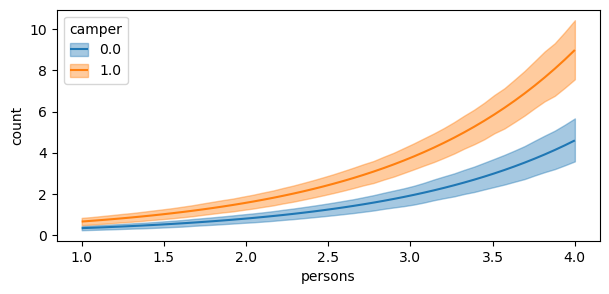

In [11]:
fig, ax = plot_comparison(
    model=fish_model,
    idata=fish_idata,
    contrast="livebait",
    conditional=["persons", "camper"],
) 
fig.set_size_inches(7, 3)

### Unit level contrasts

Evaluating average predictive comparisons at central values for the conditional covariates $v$ can be problematic when the inputs have a large variance since no single central value (mean, median, etc.) is representative of the covariate. This is especially true when $v$ exhibits bi or multimodality. Thus, it may be desireable to use the empirical distribution of $v$ to compute the predictive comparisons, and then average over a specific or set of covariates to obtain the average predictive comparisons. To achieve unit level contrasts, do not pass a parameter into `conditional` and or specify `None`.

In [37]:
unit_level = comparisons(
    model=fish_model,
    idata=fish_idata,
    contrast="livebait",
    conditional=None,
)

# empirical distribution
print(unit_level.shape[0] == fish_model.data.shape[0])
unit_level.head(10)

True


,term,contrast,camper,child,persons,estimate,hdi_0.03%,hdi_0.97%
0,livebait,"(0.0, 1.0)",0.0,0.0,1.0,0.868743,0.634292,1.121583
1,livebait,"(0.0, 1.0)",1.0,0.0,1.0,1.700244,1.307142,2.120623
2,livebait,"(0.0, 1.0)",0.0,0.0,1.0,0.868743,0.634292,1.121583
3,livebait,"(0.0, 1.0)",1.0,1.0,2.0,1.011327,0.760836,1.249259
4,livebait,"(0.0, 1.0)",0.0,0.0,1.0,0.868743,0.634292,1.121583
5,livebait,"(0.0, 1.0)",1.0,2.0,4.0,1.454320,0.961899,1.947773
6,livebait,"(0.0, 1.0)",0.0,1.0,3.0,1.236932,0.899355,1.543456
7,livebait,"(0.0, 1.0)",0.0,3.0,4.0,0.188411,0.090118,0.288605
8,livebait,"(0.0, 1.0)",1.0,2.0,3.0,0.607264,0.395854,0.826614
9,livebait,"(0.0, 1.0)",1.0,0.0,1.0,1.700244,1.307142,2.120623


#### Marginalizing over covariates

Since the empirical distrubution is used for computing the average predictive comparisons, the same number of rows (250) is returned as the data used to fit the model. To average over a covariate, use the `average_by` argument. If `True` is passed, then `comparisons` averages over all covariates. Else, if a single or list of covariates are passed, then `comparisons` averages by the covariates passed.

In [38]:
# marginalize over all covariates
comparisons(
    model=fish_model,
    idata=fish_idata,
    contrast="livebait",
    conditional=None,
    average_by=True
)

,term,contrast,estimate,hdi_0.03%,hdi_0.97%
0,livebait,"(0.0, 1.0)",3.657341,2.99057,4.344358


In [39]:
# average by number of persons
comparisons(
    model=fish_model,
    idata=fish_idata,
    contrast="livebait",
    conditional=None,
    average_by="persons"
)

,term,contrast,persons,estimate,hdi_0.03%,hdi_0.97%
0,livebait,"(0.0, 1.0)",1.0,1.379314,1.047445,1.735029
1,livebait,"(0.0, 1.0)",2.0,1.969410,1.559249,2.374562
2,livebait,"(0.0, 1.0)",3.0,3.709952,3.076369,4.364713
3,livebait,"(0.0, 1.0)",4.0,7.369520,6.112693,8.669469


In [40]:
# average by number of persons and camper
comparisons(
    model=fish_model,
    idata=fish_idata,
    contrast="livebait",
    conditional=None,
    average_by=["persons", "camper"]
)

,term,contrast,persons,camper,estimate,hdi_0.03%,hdi_0.97%
0,livebait,"(0.0, 1.0)",1.0,0.0,0.868743,0.634292,1.121583
1,livebait,"(0.0, 1.0)",1.0,1.0,1.700244,1.307142,2.120623
2,livebait,"(0.0, 1.0)",2.0,0.0,1.430712,1.095632,1.784995
3,livebait,"(0.0, 1.0)",2.0,1.0,2.350440,1.887173,2.791573
4,livebait,"(0.0, 1.0)",3.0,0.0,2.438080,1.902601,2.976076
5,livebait,"(0.0, 1.0)",3.0,1.0,4.451878,3.761067,5.174751
6,livebait,"(0.0, 1.0)",4.0,0.0,3.551448,2.698365,4.379869
7,livebait,"(0.0, 1.0)",4.0,1.0,10.751241,9.136812,12.468829


It is still possible to use `plot_comparisons` when passing an argument to `average_by`. In the plot below, the empirical distribution is used to compute unit level contrasts for `livebait` and then averaged over `persons` to obtain the average predictive comparisons. The plot below is similar to the second plot in this notebook. The differences being that: (1) a pairwise transition grid is defined for the second plot above, whereas the empirical distribution is used in the plot below, and (2) in the plot below, we marginalized over the other covariates in the model (thus the reason for not having a camper group, and a reduction in the uncertainty interval).

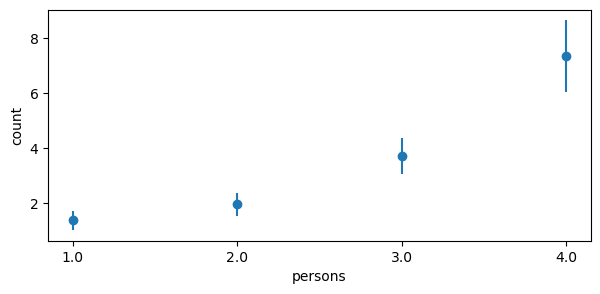

In [48]:
fig, ax = plot_comparison(
    model=fish_model,
    idata=fish_idata,
    contrast="livebait",
    conditional=None,
    average_by="persons"
)
fig.set_size_inches(7, 3)

### User specified contrast and conditional values

The modeller can also pass their own values for `contrast` and `conditional` by using a dictionary where the key, value pairs are the covariate and value(s) to use. For example, if we wanted to compare the number of fish caught for $4$ versus $1$ `persons` conditional on a range of `child` and `livebait` values, we would pass the following dictionary. However, the user is not limited to passing a list for the values. A `np.array` can also be used.

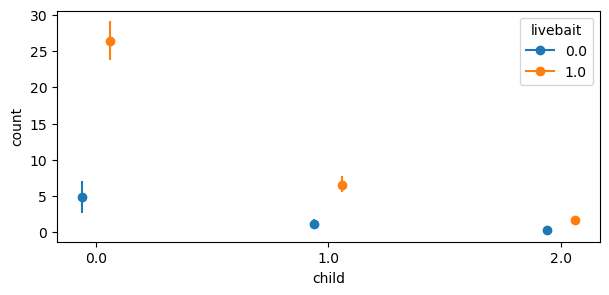

In [31]:
fig, ax = plot_comparison(
    model=fish_model,
    idata=fish_idata,
    contrast={"persons": [1, 4]},
    conditional={"child": [0, 1, 2], "livebait": [0, 1]},
) 
fig.set_size_inches(7, 3)

Notably, comparing $4$ to $1$ persons given $0$ children and using livebait, the expected difference is about $26$ fish. When not using livebait, the expected difference decreases substantially to about $5$ fish. Using livebait with a group of people is associated with a much larger expected difference in the number of fish caught. Oh, and don't bring children fishing if you have plans to catch dinner.

### Multiple contrast values

Users can also perform comparisons on multiple contrast values. For example, if we wanted to compare the number of fish caught between $(1, 2)$, $(1, 4)$, and $(2, 4)$ `persons` conditional on a range of values for `child` and `livebait`.

In [57]:
comparisons(
    model=fish_model,
    idata=fish_idata,
    contrast={"persons": [1, 2, 4]},
    conditional={"child": [0, 1, 2], "livebait": [0, 1]}
)

,term,contrast,child,livebait,camper,estimate,lower_0.03%,upper_0.97%
0,persons,"(1, 2)",0.0,0.0,1.0,0.527627,0.295451,0.775465
1,persons,"(1, 4)",0.0,0.0,1.0,2.883694,2.605690,3.177685
2,persons,"(2, 4)",0.0,0.0,1.0,0.131319,0.067339,0.195132
3,persons,"(1, 2)",0.0,1.0,1.0,0.717965,0.592968,0.857893
4,persons,"(1, 4)",0.0,1.0,1.0,0.032960,0.015212,0.052075
5,persons,"(2, 4)",0.0,1.0,1.0,0.180270,0.123173,0.244695
6,persons,"(1, 2)",1.0,0.0,1.0,4.834472,2.563472,7.037150
7,persons,"(1, 4)",1.0,0.0,1.0,26.423188,23.739729,29.072748
8,persons,"(2, 4)",1.0,0.0,1.0,1.202003,0.631629,1.780965
9,persons,"(1, 2)",1.0,1.0,1.0,6.571943,5.469275,7.642248


Notice how the contrast $u$ varies while the covariates $v$ are held constant. Currently, however, plotting multiple contrast values can be difficult to interpret since the contrast is "abstracted" away onto the y-axis. Thus, it would be difficult to interpret which portion of the plot corresponds to which contrast value. This is something I am still working on.

### Conclusion

Overall, solid progress has been made with `comparisons` and `plot_comparisons` to give the Bambi modeller insights into GLMs. One of the most difficult aspects to program is the building of the contrast dataframe (the output above) as it requires tedious shape handling to ensure the predictive comparisons are "mapped" to the correct contrast and conditional values. Writing better tests to ensure shapes are correct is something I am also working on. Additionally, there are still "nice to have" features such as:

* cross-contrasts
* comparisons other than the predictive difference (e.g., adjusted risk ratio)